In [1]:
import pandas as pd
import numpy as np
import re
import os

#Webscraping/NLP
import requests
from requests import get
from bs4 import BeautifulSoup
import time
import nltk
import requests
import unicodedata
from nltk.corpus import stopwords

#Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#My imports
import prepare as p
import acquire as a
from importlib import reload

In [2]:
#Get the data
df = pd.read_pickle('data/michelin_df.pickle')
df.head()

,name,address,location,price,cuisine,longitude,latitude,phone_number,url,website_url,award,facilities_and_services,data
0,King's Joy,"2 Wudaoying Hutong, Beijing, China Mainland","Beijing, China Mainland",¥¥¥,Vegetarian,116.410004,39.946681,8.610840e+11,https://guide.michelin.com/en/beijing-municipa...,NaN,3 MICHELIN Stars,"Air conditioning,American Express credit card,...","Just a stone’s throw from Yonghe Temple, this ..."
1,Xin Rong Ji (Xinyuan South Road),"1F, East Tower, Genesis Beijing, 8 Xinyuan Sou...","Beijing, China Mainland",¥¥¥¥,Taizhou,116.450148,39.946380,8.610650e+11,https://guide.michelin.com/en/beijing-municipa...,NaN,3 MICHELIN Stars,"Air conditioning,Car park,China UnionPay,Count...",This branch of the chain restaurant opened in ...
2,Taian Table,"101-102, Building No. 1, Garden Office, No.161...","Shanghai, China Mainland",¥¥¥¥,Innovative,121.474049,31.221807,8.617302e+12,https://guide.michelin.com/en/shanghai-municip...,https://taian-table.cn/,3 MICHELIN Stars,"Air conditioning,American Express credit card,...",A fixture on the city’s dining scene since 201...
3,Ultraviolet by Paul Pairet,'somewhere in Shanghai' - meet at Mr & Mrs Bun...,"Shanghai, China Mainland",¥¥¥¥,Innovative,121.485090,31.240358,NaN,https://guide.michelin.com/en/shanghai-municip...,https://uvbypp.cc/,3 MICHELIN Stars,"Air conditioning,American Express credit card,...",This multi-sensory experience at a secret loca...
4,Quince,"470 Pacific Ave., San Francisco, 94133, USA","San Francisco, USA",$$$$,"Contemporary, Californian",-122.403261,37.797505,1.415776e+10,https://guide.michelin.com/en/california/san-f...,http://www.quincerestaurant.com,3 MICHELIN Stars,"Air conditioning,American Express credit card,...","An air of refinement infuses this dining room,..."


In [3]:
#TODO make visualization of distribution of Michelin star levels

In [4]:
#TODO drop phone number column?

In [5]:
# # Turn NaN values in price to nothing, so that it can be recast into the price_level column
# df['price'] = df['price'].fillna('').astype('str')

In [6]:
# #Casting a new column, price level, using length of column
# df['price_level'] = df['price'].apply(lambda x: len(x))

In [7]:
# #Setting mode of this column
# mode= df.price_level.mode()[0]
# mode

In [8]:
# #Imputing 0s in price level with the mode for this column
# df['price_level'] = df['price_level'].replace(0, mode)

In [9]:
#Separate City and country columns to create two new columns
df.location

0        Beijing, China Mainland
1        Beijing, China Mainland
2       Shanghai, China Mainland
3       Shanghai, China Mainland
4             San Francisco, USA
                  ...           
6775              Warsaw, Poland
6776              Cracow, Poland
6777              Cracow, Poland
6778              Warsaw, Poland
6779              Warsaw, Poland
Name: location, Length: 6780, dtype: object

In [10]:
# #splitting location columns into two columns
# df[['city', 'country']] = df['location'].str.split(',', 1, expand=True)

In [11]:
# #Dropping phone number column
# df = df.drop(['phone_number'], axis=1)

In [12]:
# #Dropping website url column
# df = df.drop(['website_url'], axis=1)

In [13]:
# #lower case all column values if column is object/string type
# df = df.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)

In [14]:
#TODO Create clean dtypes function

In [15]:
# #Turn city/states into city states, impute city into country column
# df['country'] = np.where(pd.isna(df['country']), df['city'], df['country'])

In [16]:
#For testing this function, getting clean data
df = pd.read_pickle('data/michelin_df.pickle')
df.head()

,name,address,location,price,cuisine,longitude,latitude,phone_number,url,website_url,award,facilities_and_services,data
0,King's Joy,"2 Wudaoying Hutong, Beijing, China Mainland","Beijing, China Mainland",¥¥¥,Vegetarian,116.410004,39.946681,8.610840e+11,https://guide.michelin.com/en/beijing-municipa...,NaN,3 MICHELIN Stars,"Air conditioning,American Express credit card,...","Just a stone’s throw from Yonghe Temple, this ..."
1,Xin Rong Ji (Xinyuan South Road),"1F, East Tower, Genesis Beijing, 8 Xinyuan Sou...","Beijing, China Mainland",¥¥¥¥,Taizhou,116.450148,39.946380,8.610650e+11,https://guide.michelin.com/en/beijing-municipa...,NaN,3 MICHELIN Stars,"Air conditioning,Car park,China UnionPay,Count...",This branch of the chain restaurant opened in ...
2,Taian Table,"101-102, Building No. 1, Garden Office, No.161...","Shanghai, China Mainland",¥¥¥¥,Innovative,121.474049,31.221807,8.617302e+12,https://guide.michelin.com/en/shanghai-municip...,https://taian-table.cn/,3 MICHELIN Stars,"Air conditioning,American Express credit card,...",A fixture on the city’s dining scene since 201...
3,Ultraviolet by Paul Pairet,'somewhere in Shanghai' - meet at Mr & Mrs Bun...,"Shanghai, China Mainland",¥¥¥¥,Innovative,121.485090,31.240358,NaN,https://guide.michelin.com/en/shanghai-municip...,https://uvbypp.cc/,3 MICHELIN Stars,"Air conditioning,American Express credit card,...",This multi-sensory experience at a secret loca...
4,Quince,"470 Pacific Ave., San Francisco, 94133, USA","San Francisco, USA",$$$$,"Contemporary, Californian",-122.403261,37.797505,1.415776e+10,https://guide.michelin.com/en/california/san-f...,http://www.quincerestaurant.com,3 MICHELIN Stars,"Air conditioning,American Express credit card,...","An air of refinement infuses this dining room,..."


In [17]:
# def create_features(df):
#     '''
#     This function takes in the dataframe, drops unnecessary columns,
#     and creates new columns/features for exploration and potential
#     classification purposes. It returns the dataframe with applications
#     '''
#     # Dropping unnecessary columns
#     df = df.drop(['phone_number', 'website_url'], axis=1)
    
#     #lower case all column values if column is object/string type
#     df = df.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)
    
#     # Turn NaN values in price to 'nothing', so that it can be recast into the price_level column
#     df['price'] = df['price'].fillna('').astype('str')
#     # Casting a new column, price level, using length of column
#     df['price_level'] = df['price'].apply(lambda x: len(x))
#     # impute price level "0" with the mode for this column
#     mode= df.price_level.mode()[0]
#     df['price_level'] = df['price_level'].replace(0, mode)
    
#     # splitting location columns into two columns
#     df[['city', 'country']] = df['location'].str.split(', ', 1, expand=True)
#     # Turn city/states into city states, impute city into country column (i.e Hong Kong, Hong Kong)
#     df['country'] = np.where(pd.isna(df['country']), df['city'], df['country'])

#     return df


In [18]:
#For testing this function, getting clean data
df = pd.read_pickle('data/michelin_df.pickle')
df.head()

,name,address,location,price,cuisine,longitude,latitude,phone_number,url,website_url,award,facilities_and_services,data
0,King's Joy,"2 Wudaoying Hutong, Beijing, China Mainland","Beijing, China Mainland",¥¥¥,Vegetarian,116.410004,39.946681,8.610840e+11,https://guide.michelin.com/en/beijing-municipa...,NaN,3 MICHELIN Stars,"Air conditioning,American Express credit card,...","Just a stone’s throw from Yonghe Temple, this ..."
1,Xin Rong Ji (Xinyuan South Road),"1F, East Tower, Genesis Beijing, 8 Xinyuan Sou...","Beijing, China Mainland",¥¥¥¥,Taizhou,116.450148,39.946380,8.610650e+11,https://guide.michelin.com/en/beijing-municipa...,NaN,3 MICHELIN Stars,"Air conditioning,Car park,China UnionPay,Count...",This branch of the chain restaurant opened in ...
2,Taian Table,"101-102, Building No. 1, Garden Office, No.161...","Shanghai, China Mainland",¥¥¥¥,Innovative,121.474049,31.221807,8.617302e+12,https://guide.michelin.com/en/shanghai-municip...,https://taian-table.cn/,3 MICHELIN Stars,"Air conditioning,American Express credit card,...",A fixture on the city’s dining scene since 201...
3,Ultraviolet by Paul Pairet,'somewhere in Shanghai' - meet at Mr & Mrs Bun...,"Shanghai, China Mainland",¥¥¥¥,Innovative,121.485090,31.240358,NaN,https://guide.michelin.com/en/shanghai-municip...,https://uvbypp.cc/,3 MICHELIN Stars,"Air conditioning,American Express credit card,...",This multi-sensory experience at a secret loca...
4,Quince,"470 Pacific Ave., San Francisco, 94133, USA","San Francisco, USA",$$$$,"Contemporary, Californian",-122.403261,37.797505,1.415776e+10,https://guide.michelin.com/en/california/san-f...,http://www.quincerestaurant.com,3 MICHELIN Stars,"Air conditioning,American Express credit card,...","An air of refinement infuses this dining room,..."


In [3]:
train, validate, test = p.prepare_michelin(df)

In [4]:
train.head()

,name,address,location,price,cuisine,longitude,latitude,url,award,facilities_and_services,data,price_level,city,country,clean,lemmatized,word_count
6345,gasthaus ödenturm,"am ödenturm 11, cham, 93413, germany","cham, germany",€,"country cooking, mediterranean cuisine",12.703851,49.210919,https://guide.michelin.com/en/bayern/cham/rest...,bib gourmand,"car park,credit card / debit card accepted,gre...","as if straight out of a picture book, this bea...",1,cham,germany,straight picture book beautiful inn stands edg...,straight picture book beautiful inn stand edge...,38
6427,weinhaus anker,"obertorstraße 13, marktheidenfeld, 97828, germany","marktheidenfeld, germany",€,"french, country cooking",9.600301,49.845621,https://guide.michelin.com/en/bayern/marktheid...,bib gourmand,"american express credit card,car park,credit c...",a restaurant that is steeped in tradition and ...,1,marktheidenfeld,germany,steeped tradition run great commitment lovely ...,steeped tradition run great commitment lovely ...,35
5217,yang bao bao (nanzih),"106 chaoming road, nanzih district, kaohsiung,...","kaohsiung, taipei & taichung",$,dumplings,120.328050,22.724160,https://guide.michelin.com/en/kaohsiung-region...,bib gourmand,"air conditioning,car park,cash only","in 1993, this dumpling shop began life as a st...",1,kaohsiung,taipei & taichung,1993 dumpling shop began life street stall loc...,1993 dumpling shop began life street stall loc...,49
3858,le bistrot gastronómico,"temprado 12, castelló de la plana, 12002, spain","castelló de la plana, spain",€€,fusion,-0.037028,39.983588,https://guide.michelin.com/en/comunidad-valenc...,bib gourmand,"air conditioning,american express credit card,...","an unpretentious, friendly and informal restau...",2,castelló de la plana,spain,unpretentious friendly informal whose aim prov...,unpretentious friendly informal whose aim prov...,49
124,fat duck,"high street, bray, sl6 2aq, united kingdom","bray, united kingdom",££££,creative,-0.701753,51.507858,https://guide.michelin.com/en/windsor-and-maid...,3 michelin stars,"air conditioning,american express credit card,...",this iconic restaurant celebrated its 25-year ...,4,bray,united kingdom,iconic celebrated 25year anniversary 2021 intr...,iconic celebrated 25year anniversary 2021 intr...,40


In [21]:
# df[df.data == 'None']

In [22]:
#Code for removing former michelin restaurants still in df
# df = df[df.data != 'None']

In [23]:
# # Creating column with length of clean words
# df['lemm_wordcount'] = df.lemmatized.str.split().apply(len)

In [5]:
#Making an empty list of words
words = []
for i in train['lemmatized']:
    for word in i.split(): #Splitting the sentence into words
        words.append(word) #appending each word to the list

In [6]:
#Turning into series based on value counts
word_freq = pd.Series(words).value_counts()

In [7]:
word_freq.sort_values(ascending=False).head(50)

dish            1954
ingredient      1183
also             997
flavour          969
wine             957
'                867
modern           831
room             778
kitchen          713
one              661
local            655
food             582
fish             580
set              565
cooking          552
produce          541
sauce            523
traditional      523
like             480
served           471
offer            470
make             469
culinary         465
take             457
two              454
well             453
table            450
classic          449
service          448
seasonal         440
experience       436
made             402
terrace          402
come             398
guest            395
menu             391
pork             390
la               390
team             388
rice             386
small            385
name             383
elegant          380
feature          380
fine             375
meat             372
contemporary     369
vegetable    

In [8]:
word_freq.sort_values(ascending=False).tail(50)

daechuns            1
diversify           1
rekindles           1
booklet             1
seesawing           1
beuscherl           1
backlikely          1
weekfor             1
kojacha             1
ja                  1
nimble              1
lima                1
barranco            1
kreis               1
luck                1
mit                 1
fiveskewer          1
serviettenknodel    1
berdin              1
jennifer            1
banagale            1
driver              1
sanctum             1
pacing              1
rudderfish          1
tosazu              1
vealandpork         1
lemonbe             1
ciccio              1
1916era             1
ciboule             1
loco                1
malo                1
chouin              1
snub                1
castelbrac          1
charcot             1
seaman              1
polar               1
dinan               1
hennote             1
polynesia           1
professes           1
pirate              1
eraand              1
yeongdu   

In [9]:
train.award.value_counts()

bib gourmand        1908
1 michelin star     1536
2 michelin stars     270
3 michelin stars      79
Name: award, dtype: Int64

In [10]:
#Make dataframes by award category
train_bib = train[train.award == 'bib gourmand']
train_onestar = train[train.award == '1 michelin star']
train_twostar = train[train.award == '2 michelin stars']
train_threestar = train[train.award == '3 michelin stars']

In [11]:
#Making a list of bib words
bib_words = []
for i in train_bib['lemmatized']:
    for word in i.split(): #Splitting the sentence into words
        bib_words.append(word) #appending each word to the list
        
#Making a list of one star words
onestar_words = []
for i in train_onestar['lemmatized']:
    for word in i.split(): #Splitting the sentence into words
        onestar_words.append(word) #appending each word to the list

#Making a list of two star words
twostar_words = []
for i in train_twostar['lemmatized']:
    for word in i.split(): #Splitting the sentence into words
        twostar_words.append(word) #appending each word to the list

#Making a list of three star words
threestar_words = []
for i in train_threestar['lemmatized']:
    for word in i.split(): #Splitting the sentence into words
        threestar_words.append(word) #appending each word to the list

In [12]:
#Turning into series based on value counts
bib_freq = pd.Series(bib_words).value_counts()
onestar_freq = pd.Series(onestar_words).value_counts()
twostar_freq = pd.Series(twostar_words).value_counts()
threestar_freq = pd.Series(threestar_words).value_counts()

In [13]:
#Frequency of bib gourmand words
print(bib_freq.nlargest(25))

dish           820
also           420
flavour        339
'              332
pork           331
ingredient     323
food           322
room           317
sauce          316
traditional    315
local          312
wine           296
modern         272
rice           257
like           255
noodle         252
fish           251
kitchen        250
cooking        245
offer          243
chicken        242
soup           231
made           222
one            221
meat           218
dtype: int64


In [14]:
#Frequency of one star words
print(onestar_freq.nlargest(25))

dish          908
ingredient    694
wine          566
flavour       497
also          474
modern        468
'             396
kitchen       387
room          385
one           364
produce       316
local         302
set           295
experience    269
culinary      265
cooking       257
fish          256
guest         256
elegant       255
take          254
menu          252
tasting       251
service       240
served        233
creative      231
dtype: int64


In [15]:
#Frequency of two star words
print(twostar_freq.nlargest(25))

dish          167
ingredient    124
'             112
flavour        95
also           86
wine           77
modern         76
set            69
fish           64
culinary       62
kitchen        62
creative       60
team           59
room           58
produce        58
chef           54
one            51
fine           50
elegant        50
vegetable      49
experience     43
table          42
service        42
view           41
menu           41
dtype: int64


In [16]:
#Frequency of three star words
print(threestar_freq.nlargest(25))

dish          59
ingredient    42
flavour       38
service       29
'             27
experience    27
culinary      25
one           25
team          20
make          18
wine          18
room          18
also          17
elegant       15
setting       15
tasting       15
modern        15
always        15
cooking       15
superb        14
kitchen       14
set           14
diner         14
come          14
work          14
dtype: int64


In [42]:
train.lemmatized[0]

'stone throw yonghe temple serene remodelled courtyard house feature glassroofed room honed skill grandparent name set menu available try classic sample speciality regular may opt solarterm change every 15 day live harp performance befits restaurant classy elegance'

In [17]:
# What are the countries with the most Michelin Star Restaurants?
train.country.value_counts()

france               573
japan                474
italy                385
usa                  336
germany              335
spain                285
switzerland          151
belgium              143
united kingdom       142
netherlands          128
china mainland       121
thailand             121
taipei & taichung     99
hong kong             71
singapore             70
south korea           49
portugal              40
brazil                27
denmark               27
canada                22
ireland               20
malaysia              19
austria               18
croatia               14
slovenia              13
sweden                12
dubai                 12
macau                 10
luxembourg            10
norway                 9
hungary                9
türkiye                8
greece                 7
malta                  6
finland                6
czech republic         5
abu dhabi              5
estonia                4
poland                 4
iceland                2


In [18]:
df.award.value_counts()

Bib Gourmand        3411
1 MICHELIN Star     2744
2 MICHELIN Stars     483
3 MICHELIN Stars     142
Name: award, dtype: int64

In [44]:
def get_award_freq(train):
    '''
    This function takes in the training data set and creates a countplot
    utilizing Seaborn to visualize the range and values of programming
    languages in GitHub Repositories'''
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(figsize=(9, 6))
    cpt = sns.countplot(x='award',
                        data=train,
                        palette='RdYlGn_r',
                        order = train['award'].value_counts().index)
    plt.title('Bib Gourmand is the Most Common Award Level in our Dataset')
    plt.xlabel("Award Level")
    plt.ylabel('Count of Restaurants')
    for tick in axes.xaxis.get_major_ticks():
        tick.label1.set_fontsize(10)
    plt.show()

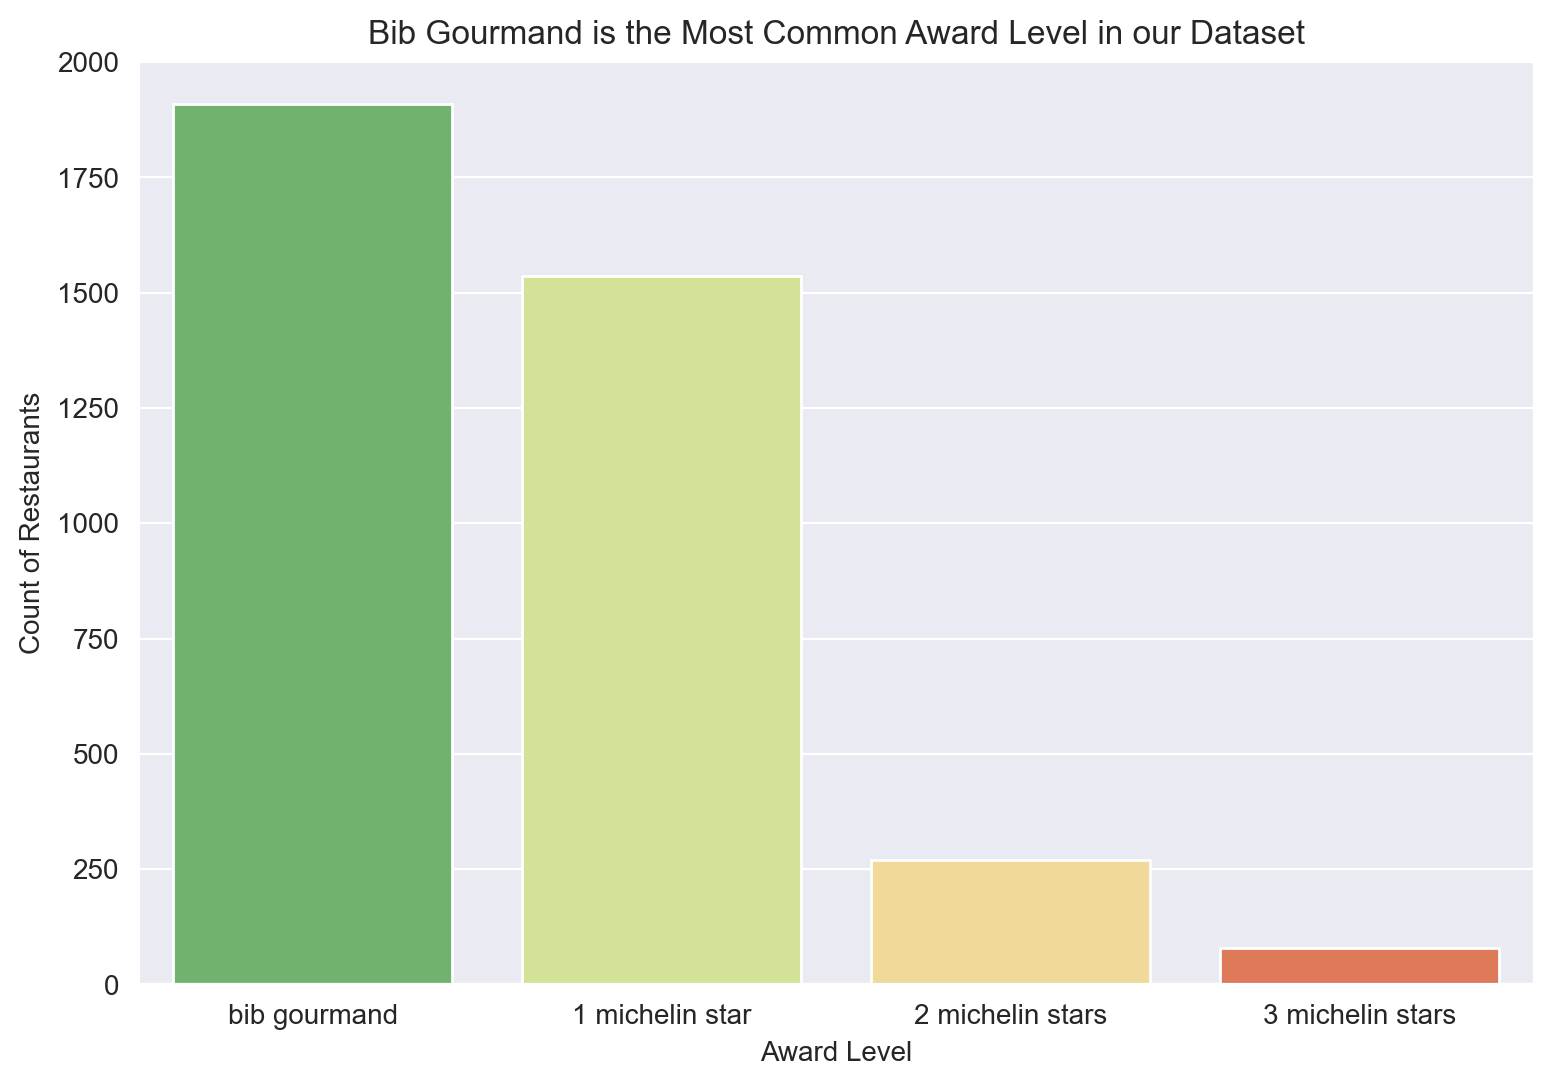

In [45]:
get_award_freq(train)

In [46]:
train.head()

,name,address,location,price,cuisine,longitude,latitude,url,award,facilities_and_services,data,price_level,city,country,clean,lemmatized,word_count
6345,gasthaus ödenturm,"am ödenturm 11, cham, 93413, germany","cham, germany",€,"country cooking, mediterranean cuisine",12.703851,49.210919,https://guide.michelin.com/en/bayern/cham/rest...,bib gourmand,"car park,credit card / debit card accepted,gre...","as if straight out of a picture book, this bea...",1,cham,germany,straight picture book beautiful inn stands edg...,straight picture book beautiful inn stand edge...,38
6427,weinhaus anker,"obertorstraße 13, marktheidenfeld, 97828, germany","marktheidenfeld, germany",€,"french, country cooking",9.600301,49.845621,https://guide.michelin.com/en/bayern/marktheid...,bib gourmand,"american express credit card,car park,credit c...",a restaurant that is steeped in tradition and ...,1,marktheidenfeld,germany,steeped tradition run great commitment lovely ...,steeped tradition run great commitment lovely ...,35
5217,yang bao bao (nanzih),"106 chaoming road, nanzih district, kaohsiung,...","kaohsiung, taipei & taichung",$,dumplings,120.328050,22.724160,https://guide.michelin.com/en/kaohsiung-region...,bib gourmand,"air conditioning,car park,cash only","in 1993, this dumpling shop began life as a st...",1,kaohsiung,taipei & taichung,1993 dumpling shop began life street stall loc...,1993 dumpling shop began life street stall loc...,49
3858,le bistrot gastronómico,"temprado 12, castelló de la plana, 12002, spain","castelló de la plana, spain",€€,fusion,-0.037028,39.983588,https://guide.michelin.com/en/comunidad-valenc...,bib gourmand,"air conditioning,american express credit card,...","an unpretentious, friendly and informal restau...",2,castelló de la plana,spain,unpretentious friendly informal whose aim prov...,unpretentious friendly informal whose aim prov...,49
124,fat duck,"high street, bray, sl6 2aq, united kingdom","bray, united kingdom",££££,creative,-0.701753,51.507858,https://guide.michelin.com/en/windsor-and-maid...,3 michelin stars,"air conditioning,american express credit card,...",this iconic restaurant celebrated its 25-year ...,4,bray,united kingdom,iconic celebrated 25year anniversary 2021 intr...,iconic celebrated 25year anniversary 2021 intr...,40


In [51]:
def get_wordcount_bar(train):
    '''
    This function takes in the training dataset and creates a bar plot of the
    average wordcount of a review based on the Michelin Star Award
    '''
    # Use groupby to get an average length per language
    review_wordcount = train.groupby('award').word_count.mean().sort_values(ascending=False)
    # Set style, make a chart
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(figsize=(9, 6))
    ax = sns.barplot(x=review_wordcount.values, 
                 y=review_wordcount.index, palette='coolwarm')
    plt.title('Average Wordcount of Michelin Star Level Restaurants')
    plt.xlabel("Average Word Count")
    plt.ylabel('Award Level')
    plt.show()

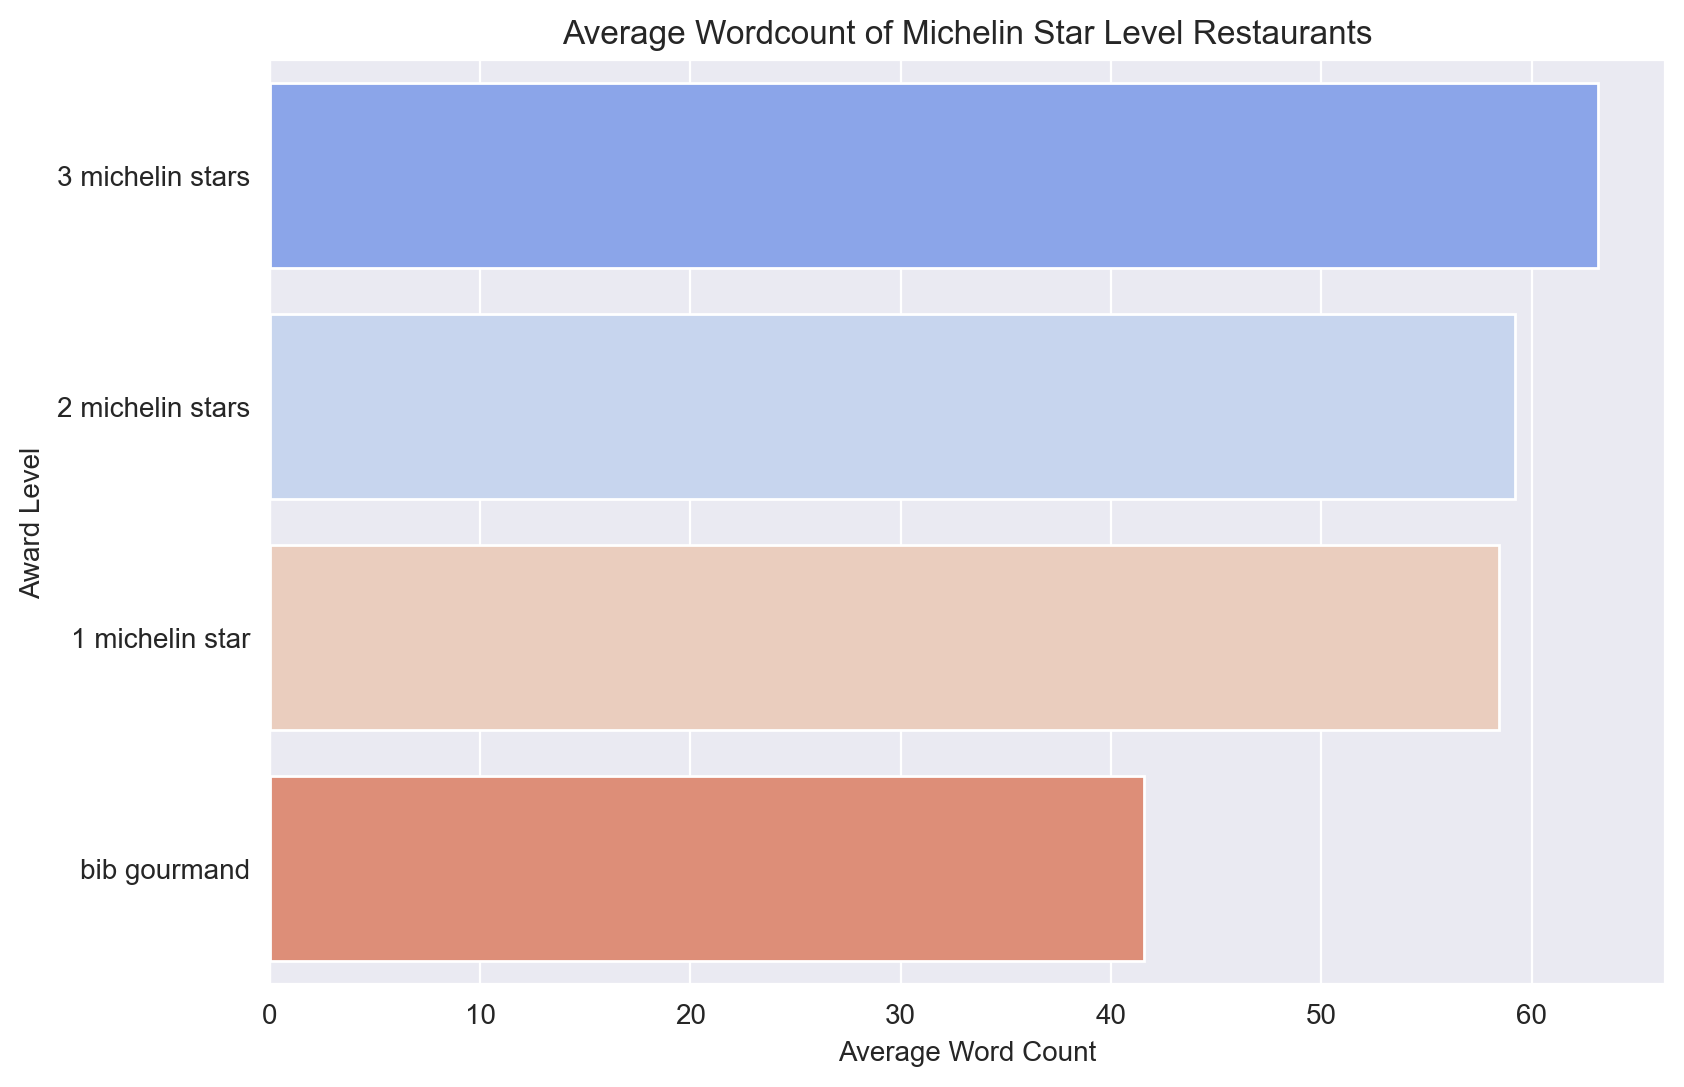

In [52]:
get_wordcount_bar(train)